# List of files exported and called: 
1. votedmetadata_streamcat_sed.csv
2. learningcurveGB_sed_baseline.jpg
3. classreportGB_sed_baseline.csv
4. confusionmatrixGB_sed_baseline.jpg
5. SHAP_sed_baseline_test.jpg
6. shap_forceplot_sed_baseline_test.htm
7. SHAP_sed_baseline_train.jpg
8. shap_forceplot_sed_baseline_train.htm

In [1]:
import pandas as pd
import shap 

In [2]:
# import dask 
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.0.117.123:8787/status,
Dashboard: http://10.0.117.123:8787/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://10.0.117.123/207/1,Workers: 1
Dashboard: http://10.0.117.123:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://10.0.117.123/207/4,Total threads: 4
Dashboard: http://10.0.117.123:40477/status,Memory: 1.86 GiB
Nanny: None,


In [3]:
data = pd.read_csv("votedmetadata_water.csv")

data

,sample_id,Cl_mgL,Dam.Upstream.Site,del18O_permil,del2H_permil,F_mgL,General_Vegetation,Hydrogeomorphology,Intermittent_or_Perennial,03_mgL,...,Precipitation.Within.Week,Primary.Sources.Flow.Variation,Sediment,SO4_mgL,Stream_Order,Temp_degC,altS,MAT,MAP,cluster
0,SW_S19S.0003_U_1,0.30,1.0,-18.75,-140.0,0.07,15,2,1,0.19,...,1.0,12,3,9.80,7.0,17.0,347.0,8.7,299.0,sw_2
1,SW_S19S.0003_U_2,0.31,1.0,NaN,NaN,0.07,15,2,1,0.23,...,1.0,12,3,8.03,7.0,17.0,347.0,8.7,299.0,sw_2
2,SW_S19S.0003_U_3,0.31,1.0,NaN,NaN,0.06,15,2,1,0.23,...,1.0,12,3,8.62,7.0,17.0,347.0,8.7,299.0,sw_0
3,SW_S19S.0004_U_1,1.83,1.0,-17.13,-129.3,0.07,7,2,1,0.12,...,1.0,12,1,6.53,6.0,18.0,346.0,7.7,449.0,sw_0
4,SW_S19S.0004_U_2,2.00,1.0,NaN,NaN,0.08,7,2,1,0.12,...,1.0,12,1,6.66,6.0,18.0,346.0,7.7,449.0,sw_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,SW_S19S.0099_U_1,70.55,1.0,-16.08,-122.8,0.33,2,1,0,4.43,...,0.0,9,1,47.79,7.0,27.3,160.0,11.8,1048.0,sw_0
261,SW_S19S.0099_U_2,68.35,1.0,NaN,NaN,0.29,2,1,0,4.64,...,0.0,9,1,45.59,7.0,27.3,160.0,11.8,1048.0,sw_0
262,SW_S19S.0099_U_3,66.16,1.0,NaN,NaN,0.30,2,1,0,4.75,...,0.0,9,1,44.37,7.0,27.3,160.0,11.8,1048.0,sw_0
263,SW_S19S.0100_U_1,0.22,1.0,-6.53,-43.3,0.09,17,1,1,0.12,...,1.0,5,1,34.62,2.0,14.2,2764.0,1.0,532.0,sw_1


In [4]:
# print all column titles 
data.columns

Index(['sample_id', 'Cl_mgL', 'Dam.Upstream.Site', 'del18O_permil',
       'del2H_permil', 'F_mgL', 'General_Vegetation', 'Hydrogeomorphology',
       'Intermittent_or_Perennial', '03_mgL', '02_mgL',
       'Number.Days.Since.Precip', 'pH', 'Precipitation.Within.Week',
       'Primary.Sources.Flow.Variation', 'Sediment', 'SO4_mgL', 'Stream_Order',
       'Temp_degC', 'altS', 'MAT', 'MAP', 'cluster'],
      dtype='object')

In [5]:
# check all the nans

print("No. of columns containing null values")
print(len(data.columns[data.isna().any()]))

print("No. of columns not containing null values")
print(len(data.columns[data.notna().all()]))

print("Total no. of columns in the dataframe")
print(len(data.columns))

No. of columns containing null values
15
No. of columns not containing null values
8
Total no. of columns in the dataframe
23


In [6]:
import numpy as np 
# drop the 'ID' column.

data2 = data.drop(['sample_id'], axis=1)

data2

,Cl_mgL,Dam.Upstream.Site,del18O_permil,del2H_permil,F_mgL,General_Vegetation,Hydrogeomorphology,Intermittent_or_Perennial,03_mgL,02_mgL,...,Precipitation.Within.Week,Primary.Sources.Flow.Variation,Sediment,SO4_mgL,Stream_Order,Temp_degC,altS,MAT,MAP,cluster
0,0.30,1.0,-18.75,-140.0,0.07,15,2,1,0.19,0.04,...,1.0,12,3,9.80,7.0,17.0,347.0,8.7,299.0,sw_2
1,0.31,1.0,NaN,NaN,0.07,15,2,1,0.23,0.04,...,1.0,12,3,8.03,7.0,17.0,347.0,8.7,299.0,sw_2
2,0.31,1.0,NaN,NaN,0.06,15,2,1,0.23,0.04,...,1.0,12,3,8.62,7.0,17.0,347.0,8.7,299.0,sw_0
3,1.83,1.0,-17.13,-129.3,0.07,7,2,1,0.12,0.04,...,1.0,12,1,6.53,6.0,18.0,346.0,7.7,449.0,sw_0
4,2.00,1.0,NaN,NaN,0.08,7,2,1,0.12,0.04,...,1.0,12,1,6.66,6.0,18.0,346.0,7.7,449.0,sw_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,70.55,1.0,-16.08,-122.8,0.33,2,1,0,4.43,0.04,...,0.0,9,1,47.79,7.0,27.3,160.0,11.8,1048.0,sw_0
261,68.35,1.0,NaN,NaN,0.29,2,1,0,4.64,0.04,...,0.0,9,1,45.59,7.0,27.3,160.0,11.8,1048.0,sw_0
262,66.16,1.0,NaN,NaN,0.30,2,1,0,4.75,0.04,...,0.0,9,1,44.37,7.0,27.3,160.0,11.8,1048.0,sw_0
263,0.22,1.0,-6.53,-43.3,0.09,17,1,1,0.12,0.04,...,1.0,5,1,34.62,2.0,14.2,2764.0,1.0,532.0,sw_1


In [7]:
data2.columns

Index(['Cl_mgL', 'Dam.Upstream.Site', 'del18O_permil', 'del2H_permil', 'F_mgL',
       'General_Vegetation', 'Hydrogeomorphology', 'Intermittent_or_Perennial',
       '03_mgL', '02_mgL', 'Number.Days.Since.Precip', 'pH',
       'Precipitation.Within.Week', 'Primary.Sources.Flow.Variation',
       'Sediment', 'SO4_mgL', 'Stream_Order', 'Temp_degC', 'altS', 'MAT',
       'MAP', 'cluster'],
      dtype='object')

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data2, test_size=0.20, random_state=42)
train # just display the train set for now. 

,Cl_mgL,Dam.Upstream.Site,del18O_permil,del2H_permil,F_mgL,General_Vegetation,Hydrogeomorphology,Intermittent_or_Perennial,03_mgL,02_mgL,...,Precipitation.Within.Week,Primary.Sources.Flow.Variation,Sediment,SO4_mgL,Stream_Order,Temp_degC,altS,MAT,MAP,cluster
172,4.28,2.0,NaN,NaN,0.08,12,1,1,0.12,0.04,...,0.0,6,1,10.91,5.0,22.1,20.0,14.0,1024.0,sw_0
232,10.80,1.0,NaN,NaN,0.12,3,1,1,0.12,0.04,...,0.0,9,1,80.07,3.0,11.5,1753.0,7.7,640.0,sw_1
18,6.96,1.0,-16.86,-127.9,0.21,3,1,1,0.12,0.04,...,1.0,5,3,160.13,6.0,25.6,1504.0,7.4,209.0,sw_0
90,2.23,2.0,-17.24,-131.3,0.11,0,2,1,0.89,0.04,...,0.0,0,1,12.11,8.0,11.0,112.0,12.0,184.0,sw_0
182,15.02,1.0,-5.86,-36.1,0.09,11,2,1,0.12,0.04,...,1.0,5,1,10.24,1.0,15.0,184.0,11.1,1160.0,sw_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,7.44,1.0,-2.90,-13.4,0.11,10,1,1,0.85,0.04,...,1.0,5,3,13.55,7.0,30.0,18.0,19.2,1255.0,sw_0
188,0.46,1.0,NaN,NaN,0.09,9,1,0,0.12,0.04,...,1.0,9,1,3.70,1.0,11.5,2535.0,3.8,485.0,sw_2
71,10.79,1.0,NaN,NaN,0.57,3,0,0,0.12,0.04,...,1.0,5,2,13.64,4.0,23.8,1788.0,7.5,641.0,sw_2
106,1719.10,2.0,0.72,8.3,0.02,4,0,1,0.54,0.04,...,1.0,17,3,209.18,1.0,29.1,5.0,23.7,1291.0,sw_0


In [9]:
# Drop the target column, that is the "cluster" column. 
# 1. Train data first. 
# Create X_train input and y_train for output (target) by dropping columns. 

X_train = train.drop(['cluster'], axis=1)

y_train = train["cluster"] 

X_train

,Cl_mgL,Dam.Upstream.Site,del18O_permil,del2H_permil,F_mgL,General_Vegetation,Hydrogeomorphology,Intermittent_or_Perennial,03_mgL,02_mgL,...,pH,Precipitation.Within.Week,Primary.Sources.Flow.Variation,Sediment,SO4_mgL,Stream_Order,Temp_degC,altS,MAT,MAP
172,4.28,2.0,NaN,NaN,0.08,12,1,1,0.12,0.04,...,5.0,0.0,6,1,10.91,5.0,22.1,20.0,14.0,1024.0
232,10.80,1.0,NaN,NaN,0.12,3,1,1,0.12,0.04,...,8.0,0.0,9,1,80.07,3.0,11.5,1753.0,7.7,640.0
18,6.96,1.0,-16.86,-127.9,0.21,3,1,1,0.12,0.04,...,8.0,1.0,5,3,160.13,6.0,25.6,1504.0,7.4,209.0
90,2.23,2.0,-17.24,-131.3,0.11,0,2,1,0.89,0.04,...,7.0,0.0,0,1,12.11,8.0,11.0,112.0,12.0,184.0
182,15.02,1.0,-5.86,-36.1,0.09,11,2,1,0.12,0.04,...,6.5,1.0,5,1,10.24,1.0,15.0,184.0,11.1,1160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,7.44,1.0,-2.90,-13.4,0.11,10,1,1,0.85,0.04,...,6.7,1.0,5,3,13.55,7.0,30.0,18.0,19.2,1255.0
188,0.46,1.0,NaN,NaN,0.09,9,1,0,0.12,0.04,...,7.0,1.0,9,1,3.70,1.0,11.5,2535.0,3.8,485.0
71,10.79,1.0,NaN,NaN,0.57,3,0,0,0.12,0.04,...,7.5,1.0,5,2,13.64,4.0,23.8,1788.0,7.5,641.0
106,1719.10,2.0,0.72,8.3,0.02,4,0,1,0.54,0.04,...,8.0,1.0,17,3,209.18,1.0,29.1,5.0,23.7,1291.0


In [10]:
y_train

172    sw_0
232    sw_1
18     sw_0
90     sw_0
182    sw_2
       ... 
20     sw_0
188    sw_2
71     sw_2
106    sw_0
102    sw_2
Name: cluster, Length: 212, dtype: object

In [11]:
# 2. Test dataset
X_test = test.drop(['cluster'], axis=1)

y_test = test["cluster"] 

X_test.head(10) # print only 10 

,Cl_mgL,Dam.Upstream.Site,del18O_permil,del2H_permil,F_mgL,General_Vegetation,Hydrogeomorphology,Intermittent_or_Perennial,03_mgL,02_mgL,...,pH,Precipitation.Within.Week,Primary.Sources.Flow.Variation,Sediment,SO4_mgL,Stream_Order,Temp_degC,altS,MAT,MAP
179,3.35,1.0,-10.86,-73.1,0.03,11,0,0,0.13,0.04,...,6.00,1.0,9,1,0.60,3.0,14.7,514.0,9.5,1837.0
115,96.69,1.0,-8.12,-58.8,0.12,2,2,1,32.71,0.29,...,7.70,1.0,19,2,121.39,NaN,20.4,46.0,9.1,549.0
96,12.52,1.0,NaN,NaN,0.05,0,2,1,18.55,0.04,...,6.50,1.0,5,1,17.95,2.0,19.5,110.0,11.4,1131.0
24,3.09,2.0,NaN,NaN,0.07,4,2,1,2.97,0.04,...,6.70,1.0,5,3,3.01,5.0,24.0,195.0,16.3,1251.0
9,311.31,1.0,NaN,NaN,0.02,3,1,1,6.43,0.04,...,7.50,0.0,5,1,33.45,2.0,25.7,115.0,12.5,1118.0
139,18.79,1.0,-4.32,-27.4,0.08,16,1,1,0.12,0.04,...,6.70,1.0,5,3,7.06,5.0,29.1,2.0,14.3,1101.0
255,12.38,3.0,NaN,NaN,0.09,3,2,1,1.05,0.04,...,8.49,0.0,15,3,14.09,5.0,16.9,1350.0,8.9,464.0
45,0.81,1.0,-6.15,-34.5,0.05,0,2,1,0.23,0.04,...,8.00,1.0,9,1,1.56,1.0,18.3,271.0,13.9,1352.0
185,20.83,1.0,-6.21,-38.1,0.06,12,2,1,0.12,0.04,...,6.50,1.0,5,1,6.94,1.0,16.0,184.0,11.1,1159.0
125,6.53,1.0,NaN,NaN,0.06,7,2,1,0.63,0.04,...,7.50,1.0,5,1,4.75,NaN,22.9,603.0,21.8,2421.0


In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier

1. Baseline model development: 
    Run SHAP on both the test and train data 

In [13]:
import time
import joblib

import numpy as np
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

start = time.time()
#classifier = RandomForestClassifier()
classifier = HistGradientBoostingClassifier() # this can handle NaNs

#rf_fitted = classifier.fit(X_train, y_train)
gb_fitted = classifier.fit(X_train, y_train) 

scores = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, n_jobs=-1)

print("training time taken: ", round(time.time() - start, 0), "seconds")
print("CV accuracy scores: %s" % scores)
print("CV accuracy:%.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

training time taken:  2.0 seconds
CV accuracy scores: [0.63636364 0.59090909 0.66666667 0.71428571 0.9047619  0.66666667
 0.61904762 0.80952381 0.76190476 0.66666667]
CV accuracy:0.704 +/- 0.091


In [14]:
#train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1, 10))
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=gb_fitted, 
                                                        X=X_train, y=y_train, cv=10, n_jobs=-1, 
                                                        scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10))

In [15]:
# get data to plot the learning curve 
from sklearn.model_selection import learning_curve

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

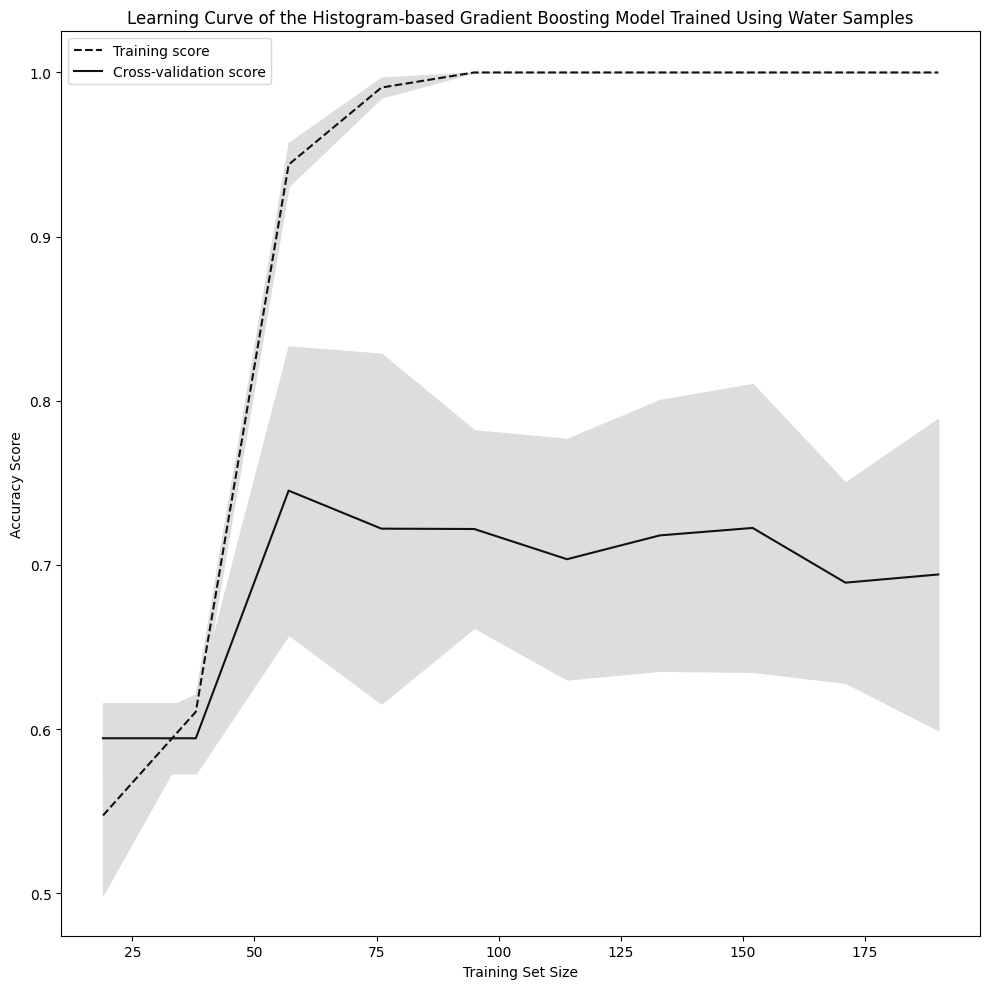

In [16]:
# plot the learning curve 
from matplotlib import pyplot as plt
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve of the Histogram-based Gradient Boosting Model Trained Using Water Samples")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig("learningcurveGB_water_baseline.jpg") # prelim interpretation: model overfit; maybe tune the model

In [17]:
test_pred = classifier.predict(X_test)

test_pred

array(['sw_2', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_2', 'sw_2',
       'sw_2', 'sw_2', 'sw_2', 'sw_0', 'sw_0', 'sw_2', 'sw_0', 'sw_0',
       'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0',
       'sw_1', 'sw_2', 'sw_2', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_2',
       'sw_0', 'sw_0', 'sw_1', 'sw_2', 'sw_0', 'sw_2', 'sw_2', 'sw_0',
       'sw_0', 'sw_1', 'sw_2', 'sw_2', 'sw_1', 'sw_2', 'sw_0', 'sw_1',
       'sw_2', 'sw_2', 'sw_0', 'sw_0', 'sw_2'], dtype=object)

In [18]:
# get the accuracy score and confusion matrix from the test set. 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(y_test, test_pred)

0.6981132075471698

In [19]:
print(f"RF train accuracy: {gb_fitted.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {gb_fitted.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.698


In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
report = classification_report(y_test, test_pred, output_dict=True)
report2 = classification_report(y_test, test_pred)
print(report2) 

# export the csv file 
df = pd.DataFrame(report).transpose()
df.to_csv('classreportGB_water_baseline.csv')

              precision    recall  f1-score   support

        sw_0       0.69      0.95      0.80        21
        sw_1       0.60      0.27      0.37        11
        sw_2       0.74      0.67      0.70        21

    accuracy                           0.70        53
   macro avg       0.68      0.63      0.62        53
weighted avg       0.69      0.70      0.67        53



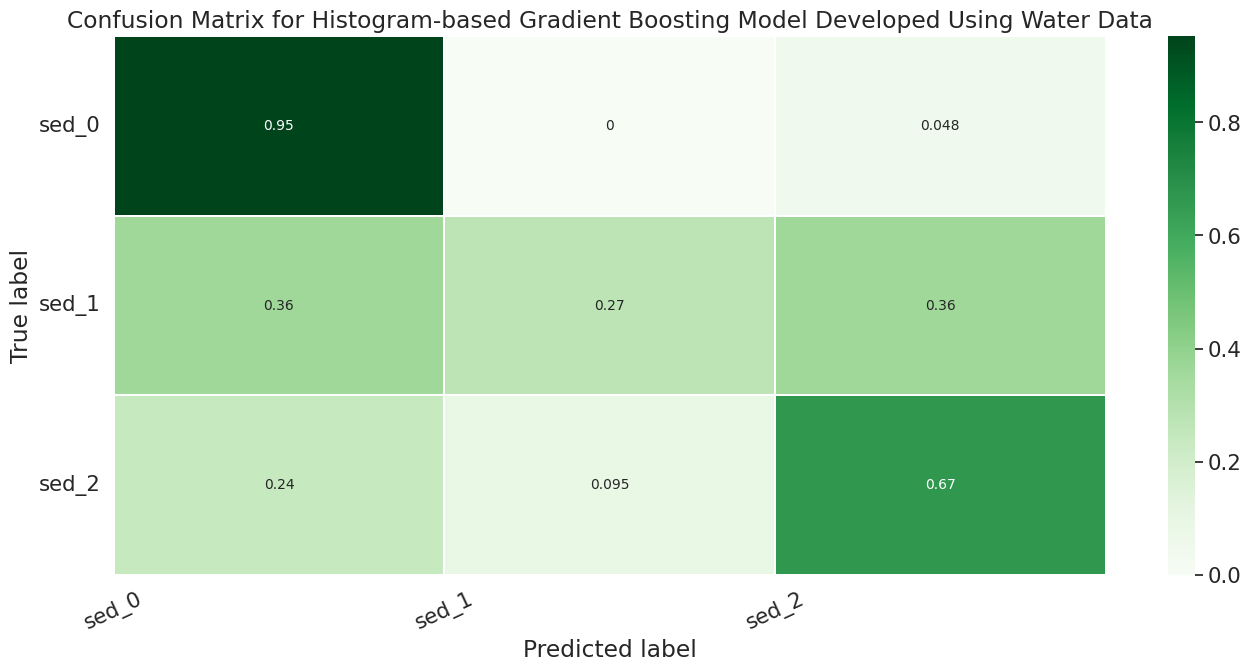

In [21]:
import seaborn as sns
matrix = confusion_matrix(y_test, test_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['sed_0', 'sed_1', 'sed_2']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Histogram-based Gradient Boosting Model Developed Using Water Data')
#plt.show() 
plt.savefig("confusionmatrixGB_sed_baseline.jpg", dpi=500, bbox_inches='tight')

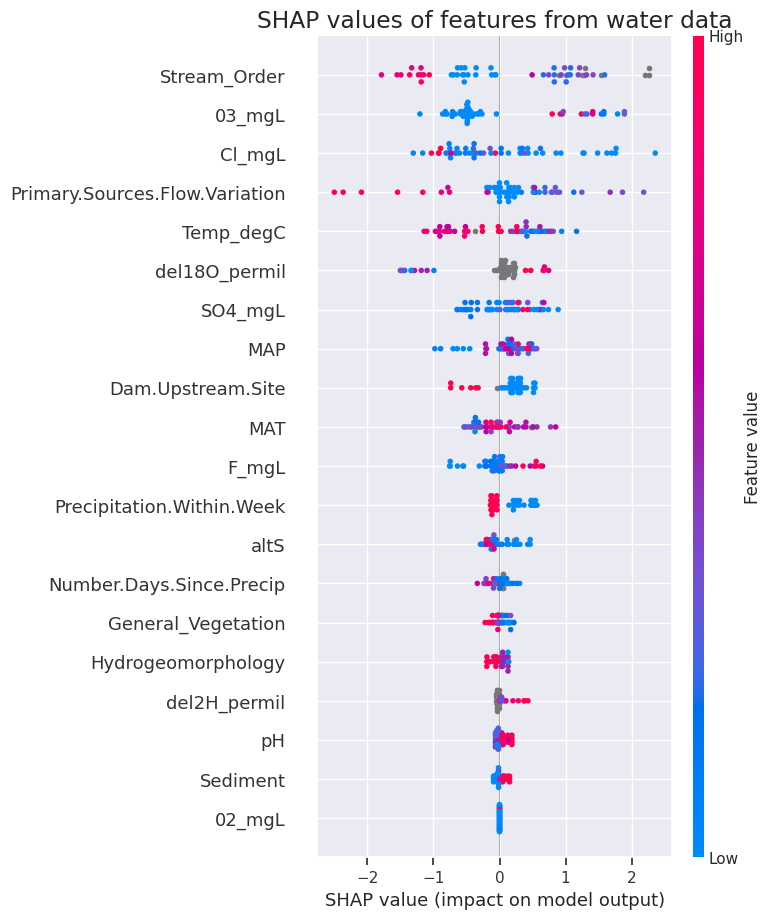

In [22]:
# Plot shap values on TEST data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_fitted)
shap_values = explainer.shap_values(X_test)
# generate a beeswarm plot 
plt.title('SHAP values of features from water data')
shap_1 = shap.summary_plot(shap_values[1], X_test, show=False)
plt.savefig("SHAP_water_baseline_test.jpg", dpi=500, bbox_inches='tight') # only can save in png
 
# prelim interpretation: 
# 1. Top 12 features have the highest variation

In [23]:
# Export FORCE PLOT on TEST data 
shap.initjs() # necessary to get the interactive graph 
explainer = shap.TreeExplainer(gb_fitted)
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)
shap.save_html("shap_forceplot_water_baseline_test.htm", f)

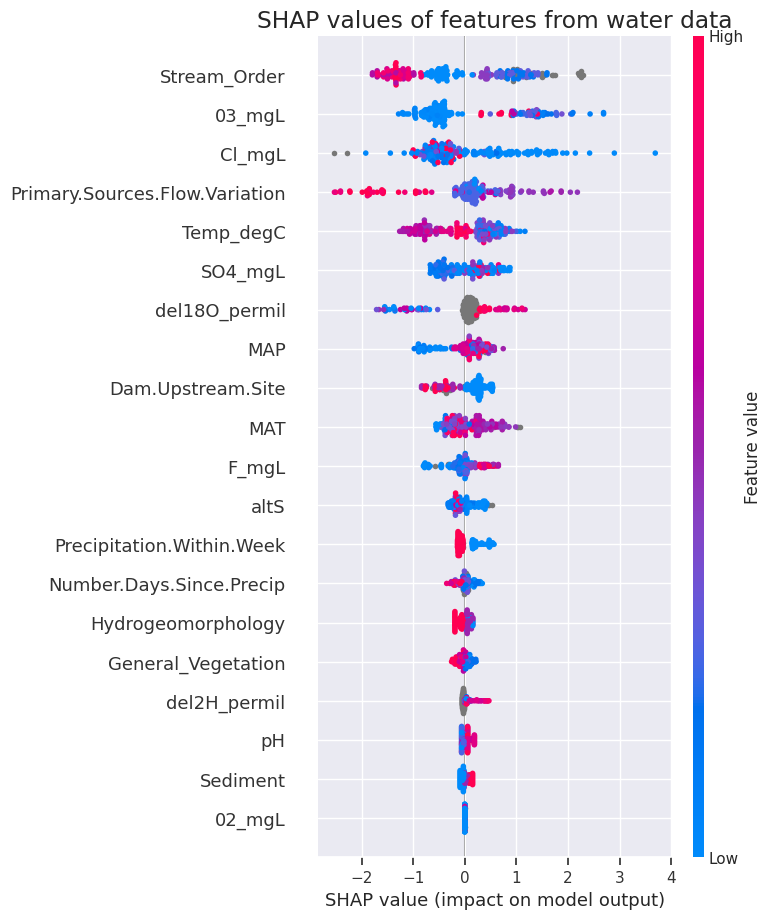

In [24]:
# Plot shapefile values on TRAINING data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_fitted)
shap_values = explainer.shap_values(X_train)
# generate a beeswarm plot 
plt.title('SHAP values of features from water data')
shap_1 = shap.summary_plot(shap_values[1], X_train, show=False)
plt.savefig("SHAP_water_baseline_train.jpg", dpi=500, bbox_inches='tight') # only can save in png

In [25]:
# Export FORCE PLOT on TRAIN data 
shap.initjs() # necessary to get the interactive graph 
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_train)
shap.save_html("shap_forceplot_water_baseline_train.htm", f)

2. Tuned model development 
    Run the analysis both on train and test data. 

from sklearn.model_selection import RandomizedSearchCV

start = time.time()

parameters_hgb = [{'max_iter': [1000,1200,1600], 
                   'learning_rate': [0.1, 0.2, 0.3], 
                   'max_depth' : [25, 50, 75], 
                   'l2_regularization': [1.5]}] 
grid_search_hgb = RandomizedSearchCV(estimator = classifier, param_distributions=parameters_hgb, 
                               scoring = 'accuracy', cv = 10, n_jobs = 1, verbose=10) # always include verbose param (in +ve integer) to monitor progress
                                # and n_jobs must be a positive number (=1)

    # grid search using dask, import joblib first   
with joblib.parallel_backend('dask'): 
    gb_fitted_tuned = grid_search_hgb.fit(X_train, y_train) 
best_accuracy_hgb = gb_fitted_tuned.best_score_ 
best_parameter_hgb = gb_fitted_tuned.best_params_

print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100)) 
print("Best Parameter of HGB:", best_parameter_hgb)
print("training time taken: ", round(time.time() - start, 0), "seconds")

cv_df = pd.DataFrame(grid_search_hgb.cv_results_).head() 
df.to_csv('tuning_result_water_tuned.csv')

# fit the tuned parameters 

start = time.time()
#classifier = RandomForestClassifier()
classifier = HistGradientBoostingClassifier(max_iter= 1000, max_depth= 50, learning_rate=0.1, l2_regularization= 1.5) # this can handle NaNs

#rf_fitted = classifier.fit(X_train, y_train)
gb_tuned = classifier.fit(X_train, y_train) 

scores = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, n_jobs=-1)

print("training time taken: ", round(time.time() - start, 0), "seconds")
print("CV accuracy scores: %s" % scores)
print("CV accuracy:%.3f +/- %.3f" % (np.mean(scores), np.std(scores))) 

# learning curve for tuned model 
train_sizes, train_scores, test_scores = learning_curve(estimator=gb_tuned, 
                                                        X=X_train, y=y_train, cv=10, n_jobs=-1, 
                                                        scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10))

# get data to plot the learning curve 
from sklearn.model_selection import learning_curve

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot the learning curve 
from matplotlib import pyplot as plt
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve of the Tuned Histogram-based Gradient Boosting Tree Model Trained Using Water Samples")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig("learningcurveGB_sed_tuned.jpg") # prelim interpretation: model overfit; maybe tune the model

Notes: 1. Should you run SHAP on test or train data? Ans: Either one, depending on what do you want to know [1] // 2. Can HGB handle different data types? Ans: Yes, all tree-based model can handle different dtypes [2] 

[1] https://datascience.stackexchange.com/questions/61395/shap-value-analysis-gives-different-feature-importance-on-train-and-test-set 
[2] https://www.quora.com/Decision-Tree-based-models-dont-require-scaling-How-does-scaling-impact-the-predictions-of-decision-tree-based-models 